# Chapter 3: Classification

In [1]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
mnist['target']

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [4]:
mnist['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

Saving figure some_digit_plot


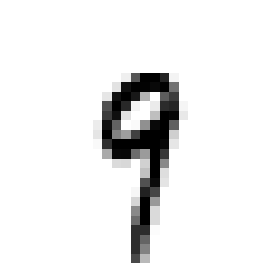

In [6]:
some_digit = X[600]
some_digit = some_digit.reshape(28, 28)

plt.imshow(some_digit, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [7]:
y[600]

'9'

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation='nearest')
    plt.axis("off")

In [10]:
#EXTRA
def plot_digits(datasets, images_per_row, **options):
    images_per_row = min(len(datasets), images_per_row)
    images = [sample.reshape(28, 28) for sample in datasets]
    n_rows = (len(datasets) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(datasets)
    images.append(np.zeros((28, 28 * n_empty)))
    digits = []
    for row in range(n_rows):
        digits.append(np.concatenate(images[row *images_per_row : (row + 1) *images_per_row], axis = 1))
    digits = np.concatenate(digits, axis=0)
    plt.imshow(digits, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

Saving figure more_digits_plot


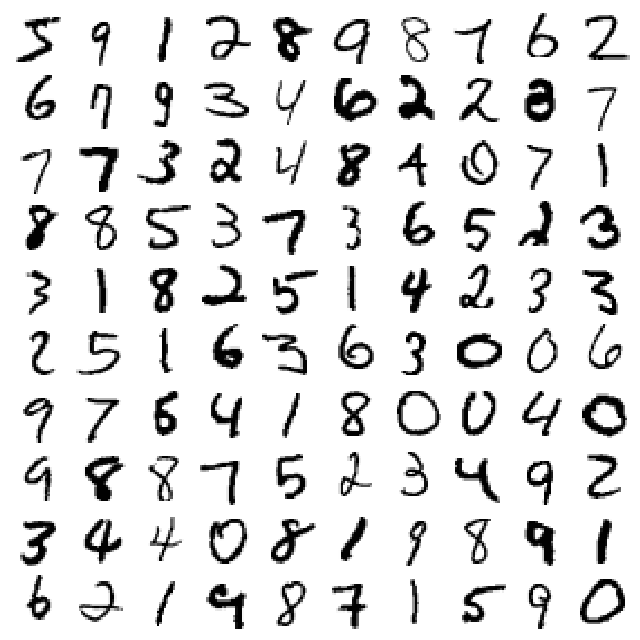

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [16]:
some_digit = X[36000:40000:500]
sgd_clf.predict(some_digit)

array([False, False, False, False, False, False, False, False])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.964 , 0.9579, 0.9571])

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.963
0.9455
0.95255


<span style="color:Tan">Let's look at a very dumb classifier that just classifies every single image in the "not-5" class</span>

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90745, 0.9125 ])

<span style="color:Wheat">
That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).
</span>

## <span style="color:Wheat">Confusion Matrix</span>

<span style="color:Wheat">A much better way to evaluate the performance of a classifier iss to look at the confusion matrix.The general idea is to count the number of times instances of class A are classified as class B</span>

In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54058,   521],
       [ 1899,  3522]], dtype=int64)

In [23]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]], dtype=int64)

## <span style="color:Wheat">Precision and Recall</span>

In [24]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,  y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8711352955725946
0.6496956281128943


In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7442941673710904

In [26]:
some_digit = X[0]
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([39607.23825616])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the predict() method (i.e., True). Let’s raise the threshold:

In [28]:
threshold = 800000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Now with these scores you can compute precision and recall for all possible thresh‐
olds using the precision_recall_curve() function:

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


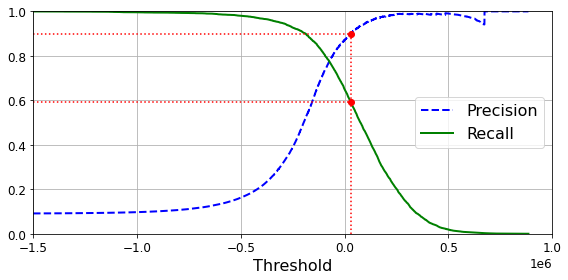

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center right", fontsize=16)
    plt.axis([-1.5e6, 1e6, 0, 1])
    plt.grid(True)
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]    
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)    
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  
plt.plot([-1.5e6, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-1.5e6, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")                                       
plt.show()

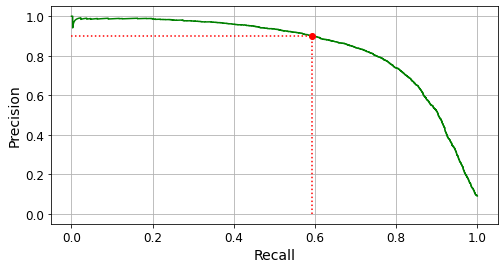

In [32]:
def plot_precision_vs_recall(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, 'g-')
    plt.grid()
    plt.xlabel("Recall")
    plt.ylabel("Precision")

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls, thresholds)
plt.plot([recall_90_precision, recall_90_precision], [0.0, 0.90], 'r:')
plt.plot([0.0, recall_90_precision], [0.90, 0.90], 'r:')
plt.plot([recall_90_precision], [0.90], "ro")
plt.show()


In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

29278.010171406935

In [34]:
y_train_pred_with_90_precision = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_with_90_precision)

0.9000559910414334

In [36]:
recall_score(y_train_5, y_train_pred_with_90_precision)

0.5930640103301974

### <span style="color:Wheat">The ROC Curve</span>

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

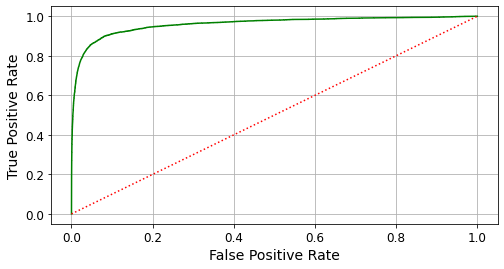

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'g-', label=label)
    plt.grid()
    plt.plot([0, 1], [0, 1], 'r:')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plt.figure(figsize=(8, 4))
plot_roc_curve(fpr, tpr)
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9598058535696421

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [41]:
y_probas_forest

array([[0.98, 0.02],
       [0.96, 0.04],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.98, 0.02]])

In [42]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

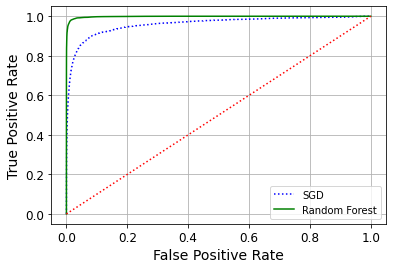

In [43]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

## <span style="color:Wheat">Multiclass Classification</span>

### <span style="color:Wheat">1. Using multiple Binary Classifiers</span>

<span style="color:Wheat">Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
class classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO).</span>

In [45]:
some_digit = X_train[:5]
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit)

array([7, 3, 8, 9, 3], dtype=uint8)

In [46]:
y_train[:5]

array([7, 3, 8, 9, 3], dtype=uint8)

In [47]:
some_digit_scores = sgd_clf.decision_function(some_digit)
print(some_digit_scores)

[[ -784788.87263852  -671548.58597178  -695539.68381451  -129605.04816887
   -287381.46346296  -256533.56454926  -496052.61839655    89784.7242425
    -55545.4413876   -155161.92625809]
 [ -337325.02724368  -520545.55938366  -531581.63079773   236265.76867767
   -407897.71102523   -50513.4448811   -386329.82861984  -941804.31758151
   -248296.67976379  -360566.56215389]
 [ -387163.03335002  -182173.37210066  -512720.17278624  -270529.90173981
   -494009.4256821     34760.02778825  -864509.82257329  -972905.71658948
    191659.26693368  -117214.69055299]
 [ -915087.71084062  -461062.07272756  -699906.50895346  -417348.79482583
    -54365.30726311  -242874.84807512  -644100.51888791  -337704.90196886
   -125497.99936952   325004.25369598]
 [ -555389.87131293  -756549.59926418  -178562.41810933   236616.73329881
   -714899.82731133   -80641.71773249  -920498.2145613  -1286056.29184055
   -371387.58704255  -828368.34887076]]


<span style="color:Wheat">
If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance
and pass a binary classifier to its constructor. For example, this code creates a multi‐
class classifier using the OvO strategy, based on a SGDClassifier:
</span>

In [48]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(some_digit)

array([7, 3, 8, 9, 3], dtype=uint8)

In [49]:
len(ovo_clf.estimators_)

45

### <span style="color:Wheat">2. Using Multiclass Classifier</span>

#### <span style="color:Wheat">RandomForest Classifier</span>

In [50]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict(some_digit)

array([7, 3, 8, 9, 3], dtype=uint8)

In [51]:
forest_clf.predict_proba(some_digit)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.01],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.99],
       [0.  , 0.  , 0.01, 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

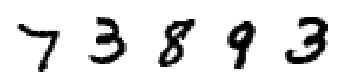

In [52]:
plot_digits(some_digit, 5)

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.83935, 0.85125, 0.8676 ])

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 4, scoring="accuracy")

array([0.9122    , 0.91106667, 0.90986667, 0.90833333])

### <span style="color:Wheat">Error Analysis</span>

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5722,    2,   28,    9,    8,   49,   51,   11,   41,    2],
       [   2, 6494,   47,   23,    6,   42,    5,   10,  100,   13],
       [  51,   37, 5360,   88,   82,   23,   96,   56,  149,   16],
       [  51,   37,  149, 5318,    2,  248,   37,   57,  134,   98],
       [  19,   25,   39,    8, 5378,    7,   54,   29,   77,  206],
       [  73,   42,   35,  170,   73, 4622,  105,   30,  177,   94],
       [  31,   24,   43,    2,   43,   88, 5635,    4,   47,    1],
       [  20,   20,   65,   27,   58,   11,    6, 5806,   12,  240],
       [  53,  147,   78,  164,   11,  163,   56,   24, 5017,  138],
       [  42,   27,   25,   87,  175,   34,    3,  201,   85, 5270]],
      dtype=int64)

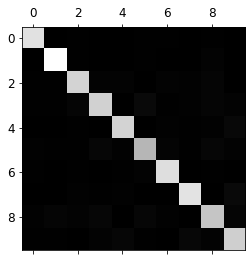

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.66064494e-01, 3.37666723e-04, 4.72733412e-03, 1.51950025e-03,
        1.35066689e-03, 8.27283471e-03, 8.61050144e-03, 1.85716698e-03,
        6.92216782e-03, 3.37666723e-04],
       [2.96647879e-04, 9.63215663e-01, 6.97122516e-03, 3.41145061e-03,
        8.89943637e-04, 6.22960546e-03, 7.41619697e-04, 1.48323939e-03,
        1.48323939e-02, 1.92821121e-03],
       [8.55991944e-03, 6.21013763e-03, 8.99630749e-01, 1.47700571e-02,
        1.37630077e-02, 3.86035582e-03, 1.61127895e-02, 9.39912722e-03,
        2.50083921e-02, 2.68546492e-03],
       [8.31838199e-03, 6.03490458e-03, 2.43027239e-02, 8.67395205e-01,
        3.26211059e-04, 4.04501713e-02, 6.03490458e-03, 9.29701517e-03,
        2.18561409e-02, 1.59843419e-02],
       [3.25231085e-03, 4.27935638e-03, 6.67579596e-03, 1.36939404e-03,
        9.20575145e-01, 1.19821979e-03, 9.24340979e-03, 4.96405341e-03,
        1.31804177e-02, 3.52618966e-02],
       [1.34661502e-02, 7.74764804e-03, 6.45637336e-03, 3.13595278e-02,
   

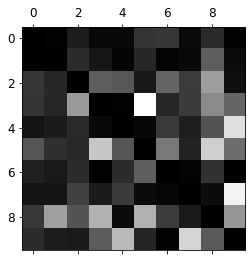

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

<span style="color:Wheat">The light squares show that multi images of couples (3, 5), (7, 9), (5, 8), (4, 9) are missclassified into the other in both directions.</span>

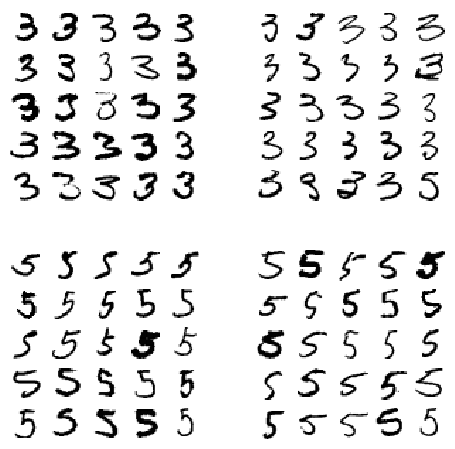

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

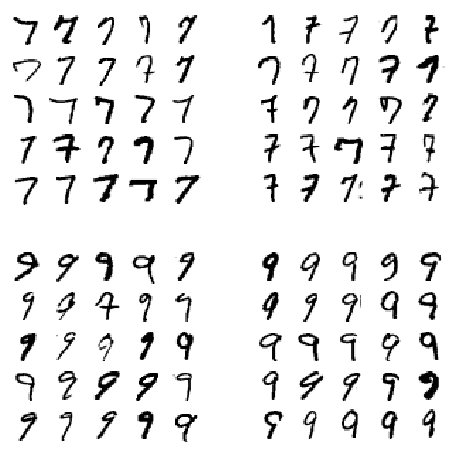

In [60]:
cl_a, cl_b = 7, 9
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

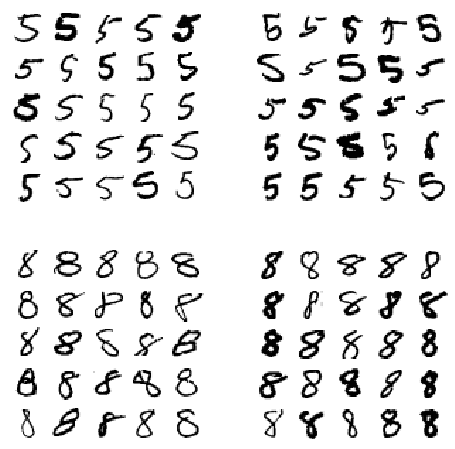

In [61]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## <span style="color:Wheat">Multilabel Classification</span>

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [63]:
knn_clf.predict(some_digit)

c:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[ True,  True],
       [False,  True],
       [ True, False],
       [ True,  True],
       [False,  True]])

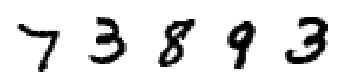

In [64]:
plot_digits(some_digit, 5)

In [65]:
# compute F1 score for above classifier
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
y_train_knn_pred

c:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

array([[ True,  True],
       [False,  True],
       [ True, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [68]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9781992561750247

## <span style="color:wheat">Multiouput Classification</span> 

<span style="color:wheat">Let’s start by creating the training and test sets by taking the MNIST images and
adding noise to their pixel intensities using NumPy’s randint() function. The target
images will be the original images:</span>

In [69]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

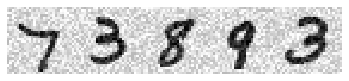

In [72]:
plot_digits(X_train_mod[:5], 10)

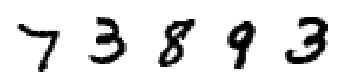

In [71]:
plot_digits(y_train_mod[:5], 10)

<Now style="color:wheat">Now
let’s train the classifier and make it clean this image:</span>

c:\Users\PC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


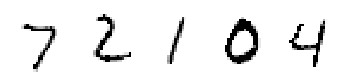

In [74]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digits = knn_clf.predict(X_test_mod[:5])
plot_digits(clean_digits, 10)